In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import re, string
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

# we need to fit model with sequence of tokens with specific length
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
# normal GRU and the Version with Cuda
from keras.layers import Dense, Embedding, GRU, LSTM, Dropout, Bidirectional
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop,Adam

# keras wrapper for k-fold cross-validation
from keras.wrappers.scikit_learn import KerasClassifier
# normal cross validation
from sklearn.model_selection import cross_val_score, train_test_split
# cross validation for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
df = pd.read_csv("C:/Users/DELL/spam.csv" ,  encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
df.rename(columns={'v1': 'Class', 'v2': 'Text'}, inplace=True)
df['Class'] = df['Class'].map({'ham':0, 'spam':1})
df.head()

,Class,Text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
stop_words = stopwords.words('english')
print(stop_words[::10])

porter = PorterStemmer()

['i', "you've", 'himself', 'they', 'that', 'been', 'a', 'while', 'through', 'in', 'here', 'few', 'own', 'just', 're', 'doesn', 'ma', "shouldn't"]


In [8]:
def clean_text(words):
    """The function to clean text"""
    words = re.sub("[^a-zA-Z]"," ", words)
    text = words.lower().split()                   
    return " ".join(text)

def remove_stopwords(text):
    """The function to removing stopwords"""
    text = [word.lower() for word in text.split() if word.lower() not in stop_words]
    return " ".join(text)

def stemmer(stem_text):
    """The function to apply stemming"""
    stem_text = [porter.stem(word) for word in stem_text.split()]
    return " ".join(stem_text)

In [9]:
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(text):
    new_text = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', text)) #remove last hashtags
    new_text2 = " ".join(word.strip() for word in re.split('#|_', new_text)) #remove hashtags symbol from words in the middle of the sentence
    return new_text2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [10]:
df['Text'] = df['Text'].apply(clean_text)
df['Text'] = df['Text'].apply(remove_stopwords)
df['Text'] = df['Text'].apply(stemmer)
df['Text'] = df['Text'].apply(strip_all_entities)
df['Text'] = df['Text'].apply(clean_hashtags)
df['Text'] = df['Text'].apply(filter_chars)
df['Text'] = df['Text'].apply(remove_mult_spaces)

In [11]:
df.head()

,Class,Text
0,0,go jurong point crazi avail bugi n great world...
1,0,ok lar joke wif u oni
2,1,free entri wkli comp win fa cup final tkt st m...
3,0,u dun say earli hor u c alreadi say
4,0,nah think goe usf live around though


In [12]:
X = df['Text']
y = df['Class']

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

vocab_size = len(tokenizer.word_index)+1
print(vocab_size)

6240


In [14]:
# divide sum of length of all sequences by number of all sequences to find averge length of each sequence
sum([len(x) for x in sequences]) // len(sequences)

8

In [15]:
pad = 'post' 
max_len = 25
embedding_size = 100
batch_size = 20
sequences = pad_sequences(sequences, maxlen=max_len, padding=pad, truncating=pad)
sequences.shape

X_train, X_test, y_train, y_test = train_test_split(sequences, y, test_size = 0.2, random_state= 0)

In [16]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# CNN Model

In [17]:
from keras.layers import Conv1D, MaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D

n_epochs = 10
model3 = Sequential()
model3.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
model3.add(Conv1D(128, 3, activation='relu'))
model3.add(MaxPool1D(3))
model3.add(Dropout(0.2))
model3.add(Conv1D(128, 3, activation='relu'))
model3.add(GlobalMaxPooling1D())
model3.add(Dropout(0.2))
model3.add(Dense(64, activation='tanh'))
model3.add(Dropout(0.2))
model3.add(Dense(32, activation='tanh'))
model3.add(Dropout(0.2))
model3.summary()
model3.add(Dense(1, activation='sigmoid'))




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 100)           624000    
                                                                 
 conv1d (Conv1D)             (None, 23, 128)           38528     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 7, 128)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 7, 128)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 5, 128)            49280     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                         

In [18]:
model3.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

In [19]:
results = model3.fit(X_train, y_train, batch_size = batch_size, epochs=n_epochs, validation_split=0.2, verbose=1)
eval_ = model3.evaluate(X_test, y_test)
print(eval_[0], eval_[1]) # loss / accuracy



Epoch 1/10
179/179 [==============================] - 8s 29ms/step - loss: 0.2089 - accuracy: 0.9285 - val_loss: 0.0458 - val_accuracy: 0.9877
Epoch 2/10
179/179 [==============================] - 5s 27ms/step - loss: 0.0419 - accuracy: 0.9905 - val_loss: 0.0552 - val_accuracy: 0.9854
Epoch 3/10
179/179 [==============================] - 4s 24ms/step - loss: 0.0199 - accuracy: 0.9950 - val_loss: 0.0594 - val_accuracy: 0.9865
Epoch 4/10
179/179 [==============================] - 5s 27ms/step - loss: 0.0077 - accuracy: 0.9989 - val_loss: 0.0944 - val_accuracy: 0.9821
Epoch 5/10
179/179 [==============================] - 5s 26ms/step - loss: 0.0032 - accuracy: 0.9992 - val_loss: 0.0884 - val_accuracy: 0.9821
Epoch 6/10
179/179 [==============================] - 5s 28ms/step - loss: 0.0035 - accuracy: 0.9986 - val_loss: 0.1006 - val_accuracy: 0.9854
Epoch 7/10
179/179 [==============================] - 5s 26ms/step - loss: 5.7917e-04 - accuracy: 1.0000 - val_loss: 0.1078 - val_accuracy: 0.

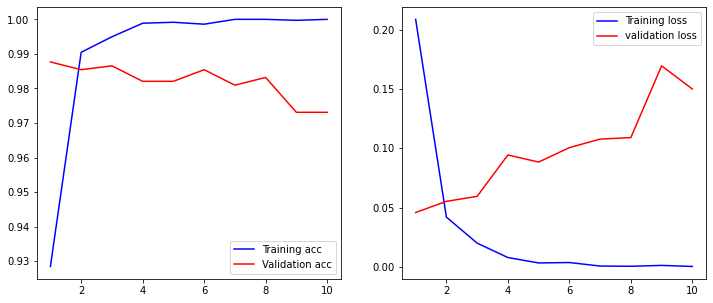

In [20]:
def plot_model(result):
    acc = result.history['accuracy']
    val_acc = result.history['val_accuracy']

    loss = result.history['loss']
    val_loss = result.history['val_loss']
    x = range(1, len(acc)+1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1,2,1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label= 'Validation acc')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='validation loss')
    plt.legend()
    
plot_model(results)

# GRU Model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 25, 100)           624000    
                                                                 
 dropout_4 (Dropout)         (None, 25, 100)           0         
                                                                 
 gru (GRU)                   (None, 140)               101640    
                                                                 
 dropout_5 (Dropout)         (None, 140)               0         
                                                                 
 Classification (Dense)      (None, 1)                 141       
                                                                 
Total params: 725,781
Trainable params: 725,781
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
179/179 [============================

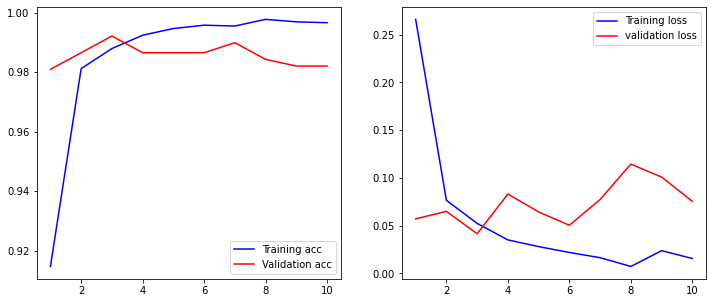

In [21]:
model1 = Sequential()
model1.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
model1.add(Dropout(0.8))
model1.add(GRU(140, return_sequences=False))
model1.add(Dropout(0.86))
model1.add(Dense(1, activation='sigmoid', name='Classification'))
model1.summary()

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
results1 = model1.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_split=0.2)

eval_ = model1.evaluate(X_test, y_test)
print(eval_[0], eval_[1]) # loss / accuracy

plot_model(results1)

# RNN Model

In [22]:
from keras.layers import SimpleRNN, Embedding, Dense

In [23]:
max_features = 10000
max_len = 500

In [24]:
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
result_rnn = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)
eval_1 = model.evaluate(X_test, y_test)

Epoch 1/10
112/112 [==============================] - 2s 7ms/step - loss: 0.2012 - acc: 0.9450 - val_loss: 0.0932 - val_acc: 0.9765
Epoch 2/10
112/112 [==============================] - 1s 5ms/step - loss: 0.0725 - acc: 0.9812 - val_loss: 0.0570 - val_acc: 0.9843
Epoch 3/10
112/112 [==============================] - 1s 5ms/step - loss: 0.0450 - acc: 0.9913 - val_loss: 0.0666 - val_acc: 0.9843
Epoch 4/10
112/112 [==============================] - 1s 5ms/step - loss: 0.0363 - acc: 0.9910 - val_loss: 0.0602 - val_acc: 0.9865
Epoch 5/10
112/112 [==============================] - 1s 5ms/step - loss: 0.0281 - acc: 0.9944 - val_loss: 0.0692 - val_acc: 0.9865
Epoch 6/10
112/112 [==============================] - 1s 5ms/step - loss: 0.0210 - acc: 0.9966 - val_loss: 0.0755 - val_acc: 0.9865
Epoch 7/10
112/112 [==============================] - 1s 5ms/step - loss: 0.0186 - acc: 0.9966 - val_loss: 0.0789 - val_acc: 0.9854
Epoch 8/10
112/112 [==============================] - 1s 5ms/step - loss: 0.

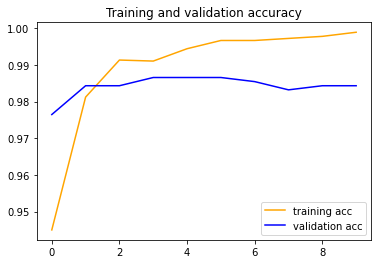

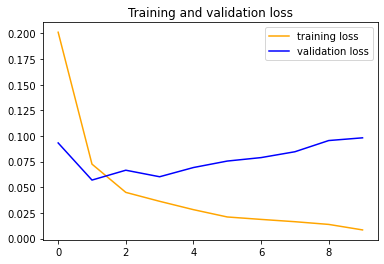

In [25]:
acc = result_rnn.history['acc']
val_acc = result_rnn.history['val_acc']
loss = result_rnn.history['loss']
val_loss = result_rnn.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, '-', color='orange', label='training acc')
plt.plot(epochs, val_acc, '-', color='blue', label='validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, '-', color='orange', label='training loss')
plt.plot(epochs, val_loss,  '-', color='blue', label='validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()